<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/Tides/LisbonTide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import matplotlib.pyplot as mpl
import numpy as np
import pandas as pd
from scipy import interpolate
import os, pathlib, subprocess

def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )
import mpl_utils as mut

mut.config_plots()
%config InlineBackend.figure_formats = ['svg']

In [19]:
if not pathlib.Path("Mares_2020_Hourly.xlsx").exists():
  cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/IST_MCTE/main/Tides/Mares_2020_Hourly.xlsx' )

In [20]:
cmdcall( 'pip install git+https://github.com/moflaher/ttide_py' )

  Cloning https://github.com/moflaher/ttide_py to /tmp/pip-req-build-ewlvld32
  Running command git clone --filter=blob:none --quiet https://github.com/moflaher/ttide_py /tmp/pip-req-build-ewlvld32
  Resolved https://github.com/moflaher/ttide_py to commit 60aa10ec4d0fb6b51640c3886ced41e86b46aefa
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [21]:
from ttide.t_tide import t_tide
from ttide.t_tide import t_predic

In [22]:
MonthsName = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
              'September', 'October', 'November', 'December']
MonthsDays = np.array( [ 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31 ] )
TotalHours = MonthsDays.sum()*24.0

Tide data retrieved from
https://webpages.ciencias.ulisboa.pt/~cmantunes/hidrografia/hidro_mares.html

In [23]:
df=pd.read_excel('Mares_2020_Hourly.xlsx', "January" )

In [24]:
Annual_Time = []
Annual_Height = []

ElapsedDays  = 0

for Nm, Name in enumerate( MonthsName ):
    df = pd.read_excel('Mares_2020_Hourly.xlsx', Name )

    for Nd in range( MonthsDays[Nm] ):
        # print( Nm+1, Name, Nd+1 )
        Height = df[ Nd+1 ]
        for Nh in range( 24 ):
            h = Height[Nh]
            t = ElapsedDays * 24.0 + Nh
            Annual_Time.append( t )
            Annual_Height.append( h )

        ElapsedDays += 1

Annual_Time = np.array( Annual_Time )

Annual_Height = np.array( Annual_Height )
# remove the mean surface water level
Annual_Height -= np.mean( Annual_Height )

(1200.0, 1320.0)

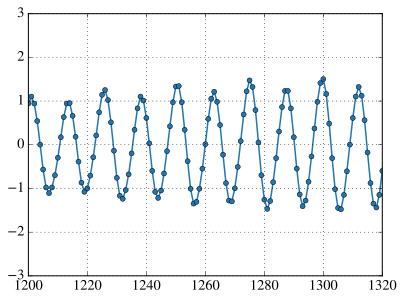

In [25]:
# piecewise linear plot of the tide
mpl.plot(Annual_Time,Annual_Height,'o-')
mpl.grid(which='both')
mpl.xlim( 1200, 1200+24*5 )

(0.0001454441043328608, 1.246710378497756)

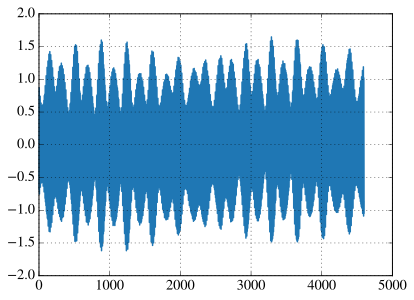

In [26]:
# define a dimensionless tide
mean_Amp = np.sqrt(2.0) * Annual_Height.std()
omega_ref = 2.0*np.pi / (12.00*3600.0)
Annual_Height_Star = Annual_Height / mean_Amp
Annual_Time_Star = (Annual_Time*3600.0) * omega_ref # convert Annual_Time to seconds
mpl.plot(Annual_Time_Star,Annual_Height_Star)
mpl.grid(which='both')
omega_ref, mean_Amp

# Use T_Tide to compute tide components

In [27]:
t_data = t_tide(Annual_Height, dt=1, out_style=None )
t_data.keys()
t_data['xout']

array([[-0.84988186],
       [-0.83311797],
       [-0.57735273],
       ...,
       [-1.19716992],
       [-1.31152007],
       [-1.06227813]])

In [28]:
TT_amp = []
TT_freq = []
TT_phase = []
TT_period = []
print( f'Comp   Per [H]  Amp [m]  Phi [°]' )
print(  '================================' )
for comp, freq, fdata in zip( t_data['nameu'], t_data['fu'], t_data['tidecon'] ):
  comp = comp.decode('ascii')
  amp = fdata[0]
  phase = fdata[2]
  period = 1.0 / freq

  TT_amp.append( amp )
  TT_freq.append( freq )
  TT_phase.append( phase )

  if amp > 0.001:
    TT_period.append( period )

    print( f'{comp}  {period:8.2f}  {amp:7.3f} {phase:8.2f}' )

Comp   Per [H]  Amp [m]  Phi [°]
SA     8766.23    0.070   109.52
2Q1      28.01    0.003    70.96
Q1       26.87    0.018    68.97
RHO1     26.72    0.003   251.52
O1       25.82    0.063    67.79
P1       24.07    0.024   256.03
K1       23.93    0.070   253.19
J1       23.10    0.003   280.48
2N2      12.91    0.028    62.17
MU2      12.87    0.026   285.48
N2       12.66    0.238    45.02
NU2      12.63    0.045   243.48
M2       12.42    1.146    22.68
LDA2     12.22    0.017   312.05
L2       12.19    0.029   157.76
T2       12.02    0.021   320.58
S2       12.00    0.392   139.48
R2       11.98    0.007   109.13
K2       11.97    0.112   311.39
M3        8.28    0.004   222.35
MN4       6.27    0.021   149.79
M4        6.21    0.057   129.94
MS4       6.10    0.031   261.89
M6        4.14    0.017   110.92
M8        3.11    0.003   252.80


# Comparison of T_Tide results with an FFT

FFT max_amp = 1.0634108812188843 [m] @ 12.424328147100425 [h]


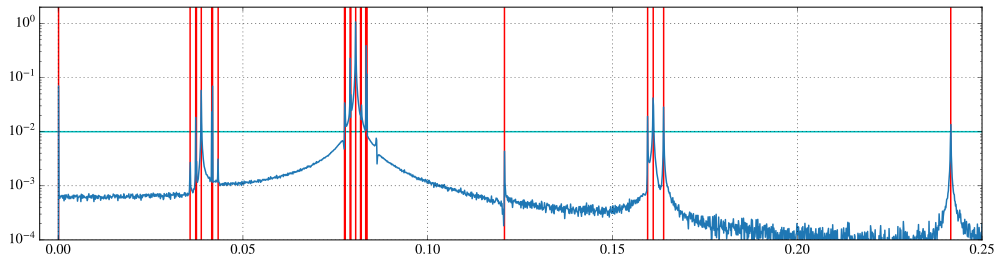

In [29]:
W = np.fft.fftfreq(Annual_Height.size, d=Annual_Time[1]-Annual_Time[0])

fsample = 1.0
delta_f = fsample / Annual_Height.size
Freqs = delta_f * np.array( range( Annual_Height.size ) )
f_hat = np.fft.fft(Annual_Height)
fft_amp = 2 / Annual_Height.size * np.abs( f_hat )
mpl.figure(figsize=(16,4))

mpl.gca().axhline( 0.01, color='c' )

for T in TT_period:
    mpl.gca().axvline( 1.0/T, color='r' )

#%matplotlib qt
mpl.grid()
mpl.semilogy( Freqs, fft_amp,lw=1.5 )
mpl.xlim( -0.005, 0.25 )
# mpl.xlim( 0.07, 0.09 )
mpl.ylim(1E-4,2)

max_amp = np.max( fft_amp )
max_freq = Freqs[ np.argmax( fft_amp ) ]
print( f'FFT max_amp = {max_amp} [m] @ {1.0/max_freq} [h]' )

# Tide spline interpolation

(1200.0, 1320.0)

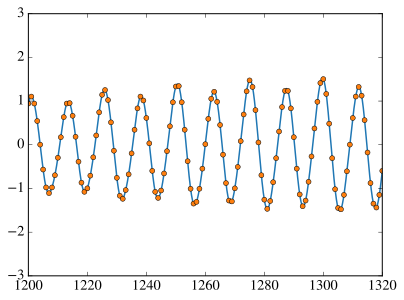

In [30]:
CS = interpolate.CubicSpline( Annual_Time, Annual_Height, bc_type='clamped' )
tnew = np.linspace(0, Annual_Time[-1], Annual_Height.size*60 )
out = CS(tnew)
mpl.plot( tnew, out )
mpl.plot(Annual_Time,Annual_Height,'o')
mpl.xlim( 1200, 1200+24*5 )